# Exploratory Data Analysis - Handwritten Math Dataset
Notebook ini digunakan untuk memahami karakteristik dataset buatan yang berisi gambar karakter matematika tulisan tangan seperti angka, beberapa huruf, dan simbol matematika. 

Fokus analisis:
- Distribusi label karakter dan simbol
- Visualisasi sampel gambar
- Deteksi gambar kosong atau rusak
- Analisis resolusi dan noise gambar
- Kualitas visual (kecerahan, kontras)  

In [1]:
%pip install pandas 
%pip install matplotlib 
%pip install numpy 
%pip install seaborn 
%pip install pillow
%pip install imagehash
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from PIL import Image, ImageStat
import imagehash
import re

## 1️⃣ Load Dataset
Membaca file CSV label dari semua folder dataset dan menampilkan beberapa contoh awal untuk memeriksa struktur data.

In [43]:
# Daftar folder dataset
folders = [
    "data/dataset_TEST",
    "data/dataset100",
    "data/dataset200",
    "data/dataset300"
]

all_dfs = []
for folder in folders:
    csv_path = os.path.join(folder, "labels.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)

        # Simpan folder dataset (penting untuk akses file gambar)
        df['folder'] = folder   

        all_dfs.append(df)
    else:
        print(f"File tidak ditemukan: {csv_path}")

merged_df = pd.concat(all_dfs, ignore_index=True)

print("Total data gabungan:", len(merged_df))
print("Total file CSV ditemukan:", len(all_dfs))
print("Daftar folder dataset:", [df['folder'].iloc[0] for df in all_dfs])

print("Total gambar:", len(merged_df))
print("Jumlah label unik:", merged_df['label'].nunique())

# Contoh ambil 3 sampel per label/font
sample_per_label = merged_df.groupby('label').head(3)
sample_per_label

Total data gabungan: 16120
Total file CSV ditemukan: 4
Daftar folder dataset: ['data/dataset_TEST', 'data/dataset100', 'data/dataset200', 'data/dataset300']
Total gambar: 16120
Jumlah label unik: 26


,filename,label,folder
0,images\test_00000_buka.png,(,data/dataset_TEST
1,images\test_00001_buka.png,(,data/dataset_TEST
2,images\test_00002_buka.png,(,data/dataset_TEST
20,images\test_00020_tutup.png,),data/dataset_TEST
21,images\test_00021_tutup.png,),data/dataset_TEST
...,...,...,...
481,images\test_00481_t.png,t,data/dataset_TEST
482,images\test_00482_t.png,t,data/dataset_TEST
500,images\test_00500_x.png,x,data/dataset_TEST
501,images\test_00501_x.png,x,data/dataset_TEST


## 2️⃣ Distribusi Label Karakter dan Simbol
Melihat proporsi semua label (angka, huruf, operator, dan simbol) untuk memastikan dataset seimbang dan model tidak bias ke satu jenis karakter.

label
0    620
1    620
2    620
3    620
4    620
5    620
6    620
7    620
8    620
9    620
+    620
-    620
x    620
/    620
c    620
o    620
s    620
t    620
a    620
n    620
g    620
l    620
=    620
(    620
)    620
Name: count, dtype: int64


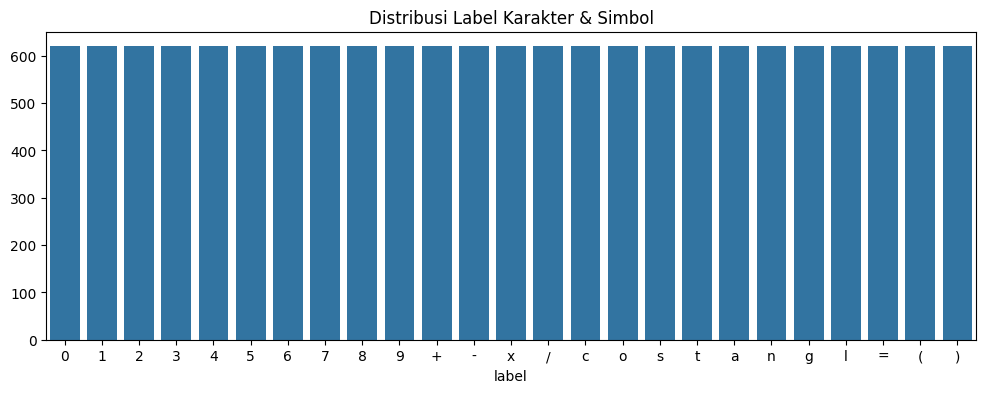

In [44]:
# Daftar semua label yang ada di dataset
all_labels = ['0','1','2','3','4','5','6','7','8','9',
              '+','-','x','/','c','o','s','t','a','n','g','l','=','(',')']

# Pastikan setiap label ada di kolom baru (opsional, kalau label sudah di 'label' cukup pakai itu)
merged_df['label'] = merged_df['label'].astype(str)  # pastikan string

# Hitung distribusi semua label
label_counts = merged_df['label'].value_counts()

# Urutkan berdasarkan all_labels
ordered_counts = label_counts.reindex(all_labels, fill_value=0)

print(ordered_counts)

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(x=ordered_counts.index, y=ordered_counts.values)
plt.title("Distribusi Label Karakter & Simbol")
plt.show()

## 3️⃣ Visualisasi Sampel Gambar
Menampilkan beberapa gambar dari setiap label untuk memastikan dataset benar.

Jumlah baris df yang diterima: 16120
Contoh label unik: ['(', ')', '+', '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'a', 'c', 'g', 'i', 'l', 'n', 'o', 's', 't', 'x']


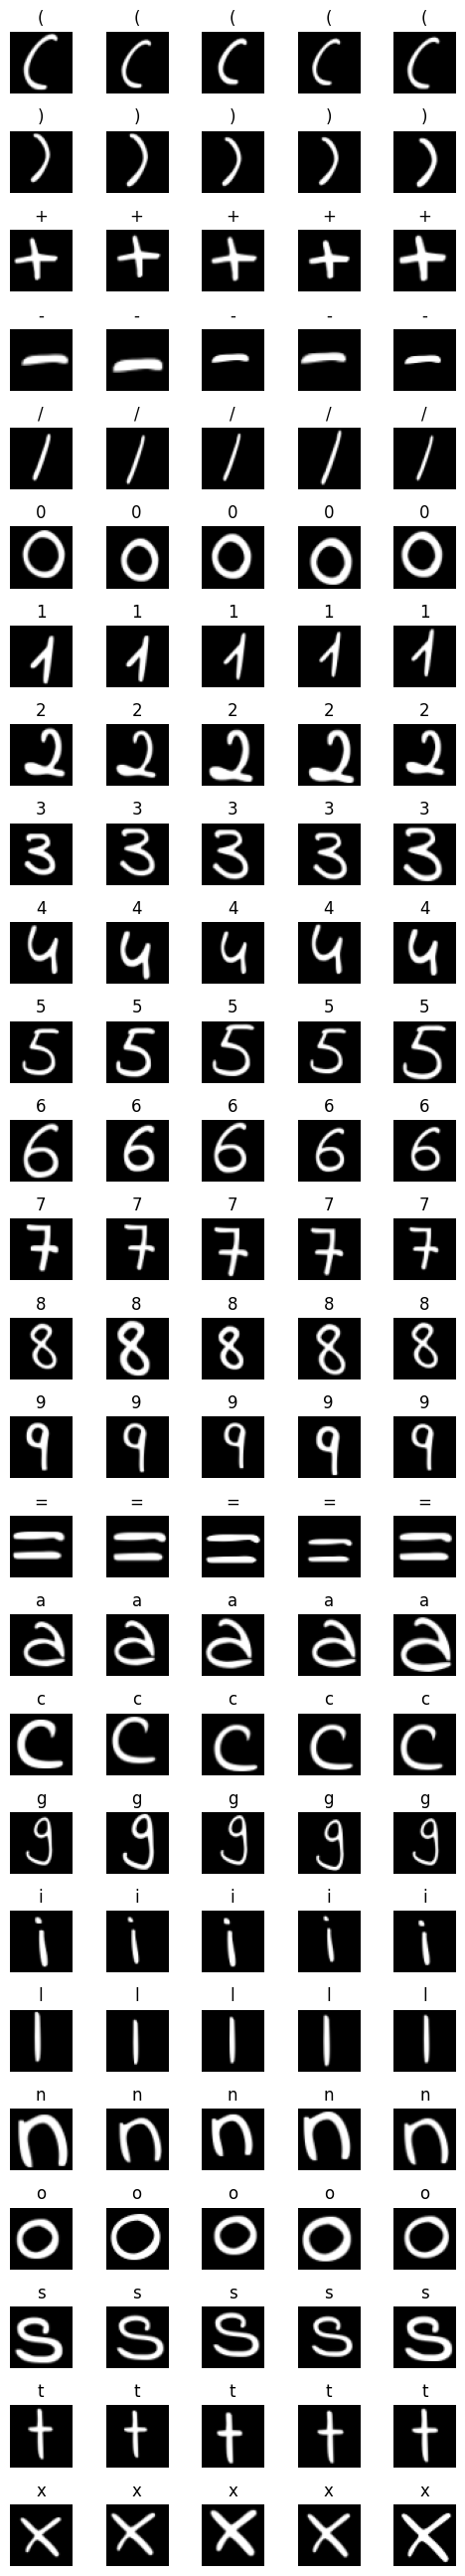

In [45]:
def show_samples(df, num_samples=5):

    # DEBUG: cek ukuran dataframe
    print("Jumlah baris df yang diterima:", len(df))
    print("Contoh label unik:", sorted(df['label'].unique()))

    labels = sorted(df['label'].unique())
    total_cols = num_samples
    total_rows = len(labels)

    plt.figure(figsize=(num_samples * 1, total_rows * 1))

    idx = 1
    for label in labels:
        subset = df[df['label'] == label].head(num_samples)

        for _, row in subset.iterrows():

            img_path = os.path.join(row['folder'], row['filename'])
            img = Image.open(img_path)

            plt.subplot(total_rows, total_cols, idx)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(label)

            idx += 1

    plt.tight_layout()
    plt.show()

show_samples(merged_df)


## 4️⃣ Deteksi Gambar Kosong atau Rusak
Memastikan kualitas dataset dengan memeriksa apakah terdapat gambar yang tidak valid.

In [46]:
from PIL import UnidentifiedImageError

corrupted_files = []

for idx, row in merged_df.iterrows():
    img_path = os.path.join(row["folder"], row["filename"])

    try:
        img = Image.open(img_path)
        img.verify()  # cek integritas
    except (UnidentifiedImageError, OSError):
        corrupted_files.append(img_path)

print("Jumlah file rusak:", len(corrupted_files))
corrupted_files[:10]

empty_files = []

for idx, row in merged_df.iterrows():
    img_path = os.path.join(row["folder"], row["filename"])
    img = Image.open(img_path).convert("L")
    arr = np.array(img)

    # Jika semua pixel hampir sama → kosong
    if arr.std() < 2:   # std sangat kecil → tidak ada variasi
        empty_files.append(img_path)

print("Jumlah gambar kosong:", len(empty_files))
empty_files[:10]

print("\n===== RINGKASAN DETEKSI =====")
print("Gambar rusak  :", len(corrupted_files))
print("Gambar kosong :", len(empty_files))

Jumlah file rusak: 0
Jumlah gambar kosong: 0

===== RINGKASAN DETEKSI =====
Gambar rusak  : 0
Gambar kosong : 0


## 5️⃣ Analisis Resolusi dan Noise Gambar
Memeriksa konsistensi resolusi seluruh gambar dalam dataset serta mengevaluasi apakah terdapat noise berlebih, artefak, atau kualitas gambar yang dapat mempengaruhi performa model OCR.

Jumlah gambar: 7800
Jumlah gagal dibuka: 0

Resolusi unik:
  resolution  count
0   (45, 45)   7800


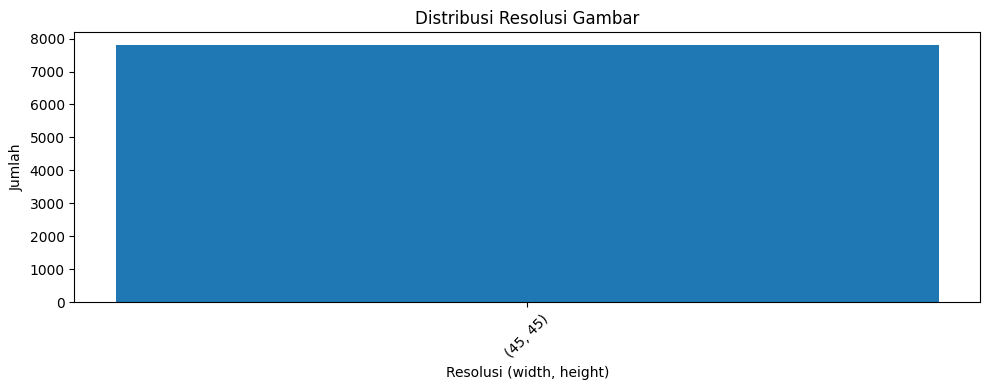

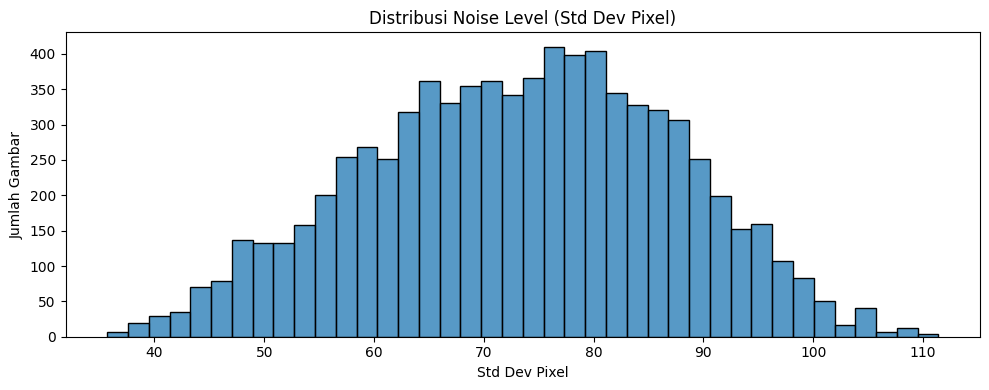

Low-noise threshold : 45.03025086601527
High-noise threshold: 99.31467178040188

Gambar sangat bersih (low-noise): 156
Gambar sangat noisy (high-noise): 158


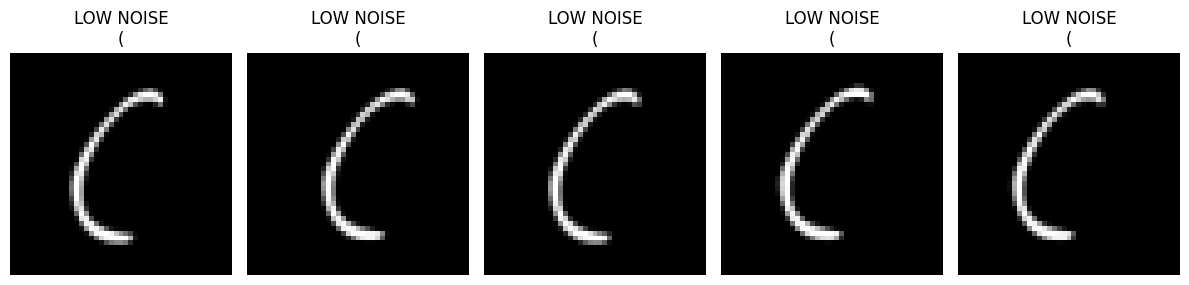

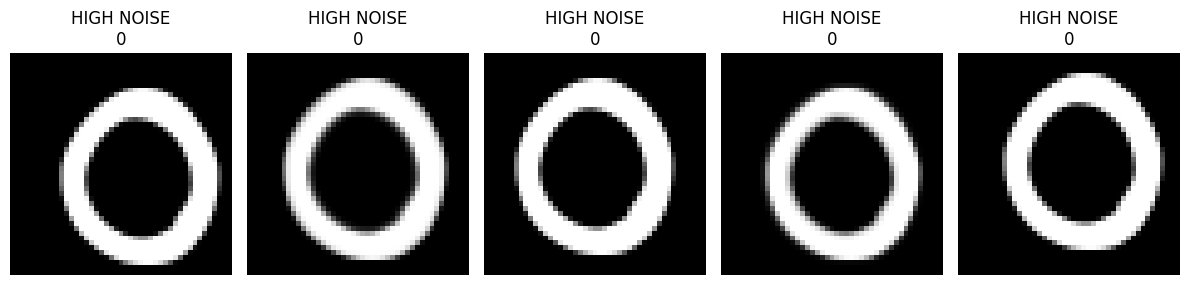

In [47]:
from collections import Counter

def analyze_resolution_and_noise(df):
    resolutions = []
    noise_levels = []
    bad_files = []

    for idx, row in df.iterrows():
        img_path = os.path.join(row['folder'], row['filename'])

        try:
            img = Image.open(img_path).convert('L')
            arr = np.array(img)

            # Resolusi
            h, w = arr.shape
            resolutions.append((w, h))

            # Noise level (std dev pixel)
            noise_levels.append(arr.std())

        except Exception as e:
            bad_files.append((img_path, str(e)))

    return resolutions, noise_levels, bad_files

resolutions, noise_levels, bad_files = analyze_resolution_and_noise(df)

print("Jumlah gambar:", len(df))
print("Jumlah gagal dibuka:", len(bad_files))
if len(bad_files) > 0:
    print("Contoh error:", bad_files[:5])

# Hitung resolusi unik
res_counter = Counter(resolutions)
res_df = pd.DataFrame(res_counter.items(), columns=["resolution", "count"])

print("\nResolusi unik:")
print(res_df)

# Plot resolusi
plt.figure(figsize=(10,4))
plt.bar([str(r) for r in res_df["resolution"]], res_df["count"])
plt.xticks(rotation=45)
plt.title("Distribusi Resolusi Gambar")
plt.xlabel("Resolusi (width, height)")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(noise_levels, bins=40)
plt.title("Distribusi Noise Level (Std Dev Pixel)")
plt.xlabel("Std Dev Pixel")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

# Cari batas outlier noise
noise_arr = np.array(noise_levels)
low_noise_threshold = np.percentile(noise_arr, 2)   # sangat bersih
high_noise_threshold = np.percentile(noise_arr, 98) # sangat noisy

print("Low-noise threshold :", low_noise_threshold)
print("High-noise threshold:", high_noise_threshold)

low_noise_idx = np.where(noise_arr <= low_noise_threshold)[0]
high_noise_idx = np.where(noise_arr >= high_noise_threshold)[0]

print("\nGambar sangat bersih (low-noise):", len(low_noise_idx))
print("Gambar sangat noisy (high-noise):", len(high_noise_idx))

def show_examples(df, idx_list, title, max_show=5):
    plt.figure(figsize=(12,3))
    for i, idx in enumerate(idx_list[:max_show]):
        row = df.iloc[idx]
        img_path = os.path.join(row["folder"], row["filename"])
        img = Image.open(img_path).convert('L')

        plt.subplot(1, max_show, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title}\n{row['label']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_examples(df, low_noise_idx, "LOW NOISE", max_show=5)
show_examples(df, high_noise_idx, "HIGH NOISE", max_show=5)

## 6️⃣ Kualitas Visual: Brightness & Contrast
Mengukur rata-rata intensitas (brightness) dan variasinya (contrast) dari sebagian gambar. Ini membantu memastikan gambar tidak terlalu gelap, terang, atau rata.

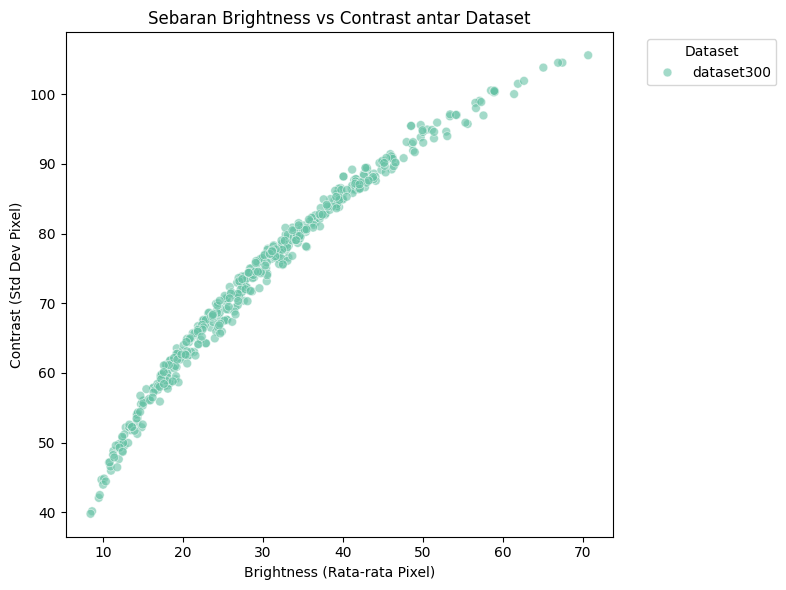

Rata-rata brightness: 30.13
Rata-rata contrast  : 73.51


In [48]:
# Ambil sampel maksimal 500 gambar
sample_df = df.sample(min(500, len(df)), random_state=42)

brightness, contrast, folders = [], [], []

for _, row in sample_df.iterrows():

    # path gambar sesuai struktur datasetmu
    img_path = os.path.join(row['folder'], row['filename'])

    if os.path.exists(img_path):
        img = Image.open(img_path).convert('L')

        stat = ImageStat.Stat(img)
        brightness.append(stat.mean[0])    # rata-rata intensitas
        contrast.append(stat.stddev[0])    # standar deviasi (kontras)
        folders.append(os.path.basename(row['folder']))  # nama folder (font set)

# dataframe hasil
vis_df = pd.DataFrame({
    'brightness': brightness,
    'contrast': contrast,
    'dataset': folders
})

# Scatter plot brightness vs contrast
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=vis_df,
    x='brightness',
    y='contrast',
    hue='dataset',
    alpha=0.6,
    s=40,
    palette='Set2'
)

plt.title('Sebaran Brightness vs Contrast antar Dataset')
plt.xlabel('Brightness (Rata-rata Pixel)')
plt.ylabel('Contrast (Std Dev Pixel)')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"Rata-rata brightness: {np.mean(brightness):.2f}")
print(f"Rata-rata contrast  : {np.mean(contrast):.2f}")

# Kesimpulan Akhir

Secara keseluruhan, dataset ini bersih, stabil, dan berkualitas baik untuk digunakan dalam pelatihan model OCR matematika atau klasifikasi karakter.
Tidak ditemukan masalah besar seperti label tidak konsisten, gambar rusak, noise berlebih, atau distribusi data yang tidak seimbang.

Dataset siap digunakan untuk tahap preprocessing lanjutan atau pelatihan model machine learning.

# Pre Processing - Handwritten Math Dataset
Notebook ini digunakan untuk menyiapkan dataset gambar tulisan tangan sebelum proses pelatihan model. Tahap pre-processing dilakukan untuk membuat gambar lebih konsisten, mudah dibaca, dan sesuai dengan format input model.

Fokus pre-processing meliputi:
- Standardisasi gambar (grayscale + resize)
- Pembersihan visual untuk mengurangi noise dan menstabilkan kualitas gambar
- Konversi gambar menjadi bentuk biner agar tulisan lebih jelas
- Normalisasi piksel sebelum digunakan model

## 1️⃣ Standardisasi gambar (grayscale + resize)

In [3]:
def standardisasi_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    return img

## 2️⃣ Pembersihan visual (noise reduction + stabilization)

In [16]:
def noise_reduction_and_stabilization(img):
    img = cv2.medianBlur(img, 3)  # mengurangi noise
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)        # stabilisasi kecerahan & kontras
    
    return img

## 3️⃣ Binarisasi (memperjelas tulisan)

In [17]:
def binarisasi(img):
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return img

## 4️⃣ Normalisasi piksel (0–1)

In [18]:
def normalisasi(img):
    img = img.astype("float32") / 255.0
    
    return img

# Penggunaan

✔ Jumlah gambar: 5200


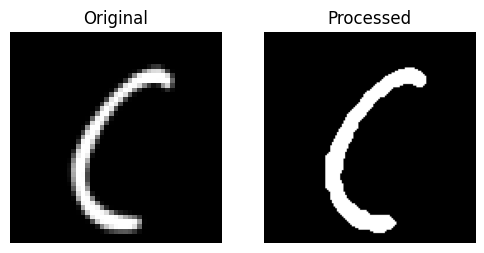

In [21]:
folder = "data/dataset200/images"
processed_images = []

for filename in os.listdir(folder):
    if filename.lower().endswith((".png")):
        path = os.path.join(folder, filename)

        img = standardisasi_image(path)
        img = noise_reduction_and_stabilization(img)
        img = binarisasi(img)
        img = normalisasi(img)

        processed_images.append((path, img))

print("✔ Jumlah gambar:", len(processed_images))

# ==== VISUALISASI HASIL (contoh 1 gambar pertama) ====
original_path, processed = processed_images[0]
original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Processed")
plt.imshow(processed, cmap='gray')
plt.axis('off')

plt.show()